In [16]:

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.transforms.v2.functional import resize
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
# import pytorch_lightning as pl

from anomalib.models.image.efficient_ad.torch_model import EfficientAdModel, EfficientAdModelSize
from anomalib.models.image.efficient_ad.lightning_model import EfficientAd
from anomalib.data import AnomalibDataModule
from anomalib.models.image.winclip.utils import visual_association_score

from glob import glob
import numpy as np
from os.path import expanduser, join, exists, basename
from os import mkdir
from shutil import rmtree

import time

import importlib
import importlib.util

# NOTE: The following MVTecLoco import is not available in anomalib v1.0.1.
# It will be available in v1.1.0 which will be released on April 29th, 2024.
# If you are using an earlier version of anomalib, you could install anomalib
# from the anomalib source code from the following branch:
# https://github.com/openvinotoolkit/anomalib/tree/feature/mvtec-loco

# from anomalib.data import MVTecLoco
# from anomalib.data.image.mvtec_loco import MVTecLoco

from anomalib.data import MVTecLoco
from anomalib.data import MVTec
from anomalib.metrics.f1_max import F1Max


In [2]:

from typing import Any, Mapping


class PretrainEfficientAD(nn.Module):
    """Example model class for track 2.

    This class applies few-shot anomaly detection using the WinClip model from Anomalib.
    """

    def __init__(self) -> None:
        super().__init__()
        
        self.EfficientAD = EfficientAd()
        self.register_buffer("_map_st", torch.empty(0))
        self.register_buffer("_map_ae", torch.empty(0))
        self.register_buffer("_ref_score", torch.empty(0))
        # NOTE: Create your transformation pipeline (if needed).
        self.EfficientAD._transform = self.EfficientAD.configure_transforms(image_size=(256, 256))
        assert self.EfficientAD._transform != None, "ERROR:: Transform should not be None."
        
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.EfficientAD.to(device)
        self.EfficientAD.eval()
        
        self.k_shot = None
        
    def forward(self, batch: torch.Tensor) -> dict[str, torch.Tensor]:
        """Transform the input batch and pass it through the model.

        This model returns a dictionary with the following keys
        - ``anomaly_map`` - Anomaly map.
        - ``pred_score`` - Predicted anomaly score.
        """
        
        batch = self.EfficientAD._transform(batch) 
        output = self.EfficientAD(batch)
        anomaly_maps, map_st, map_ae = output["anomaly_map"], output["map_st"], output["map_ae"]
        # resize back to 256x256 for evaluation
        anomaly_maps = resize(anomaly_maps, (256, 256))
        pred_score = anomaly_maps.mean()
        
        if self.k_shot is not None:
            few_shot_scores = 1-self._compute_few_shot_scores(map_st, map_ae)
            # pred_score = pred_score / self._ref_score
            pred_score = pred_score * few_shot_scores
            # anomaly_maps = (anomaly_maps + few_shot_scores) / 2
            # image_scores = (image_scores + few_shot_scores.amax(dim=(-2, -1))) / 2

        return {"pred_score": pred_score, "anomaly_map": anomaly_maps}

    def fit(self, 
            cur_epoch: int,
            datamodule: AnomalibDataModule, 
            max_epochs: int = 20,
            max_steps: int = 70000,
            # save_per_epochs: int = 50,
            ckpt_dir: str | None = None, 
            ckpt_path: str | None = None,
            ) -> None:
        
        self.train()
        self.EfficientAD.train()
        # checkpoint_callback = ModelCheckpoint(dirpath=ckpt_dir,
        #                                       filename='{cur_epoch}-{step}',
        #                                       save_last=True,
        #                                     #   every_n_epochs= save_per_epochs,
        #                                       verbose=True)
        checkpoint_callback = ModelCheckpoint(dirpath=ckpt_dir,
                                                filename='last',
                                                save_last=False,
                                                # save_top_k= 1,
                                                verbose=True,
                                                # monitor='val_loss', # or another relevant metric
                                                # mode='min'
                                                )
        self.trainer = Trainer(max_epochs=max_epochs, 
                               max_steps=max_steps, 
                               check_val_every_n_epoch = max_epochs, 
                               enable_checkpointing=True, 
                               callbacks=[checkpoint_callback],
                               default_root_dir=ckpt_dir)
        self.trainer.fit(self.EfficientAD, datamodule=datamodule, ckpt_path=ckpt_path)
        # self.trainer.save_checkpoint(ckpt_dir+f'epoch_{cur_epoch}_{datamodule.category}_weights.ckpt', weights_only=True)
        if(cur_epoch % 100 == 0):
            torch.save(self.EfficientAD.state_dict(), ckpt_dir+f'epoch_{cur_epoch}_{datamodule.category}_weights.pth')
                    
        with open("pretrain_process.txt", "a") as f:
            end_time = time.time()
            exe_time = time.strftime('%H:%M:%S',time.localtime(end_time - start_time))
            f.write(f"Epoch {cur_epoch} - Time : {exe_time} - Category : {datamodule.category}\n")
            f.close()

    def load_state_dict(self, state_dict: Mapping[str, Any], strict: bool = True, assign: bool = False):
        # super().load_state_dict(state_dict, strict, assign)
        # self.EfficientAD = EfficientAd.load_from_checkpoint(state_dict)
        self.EfficientAD.load_state_dict(state_dict)

    def setup(self, data: dict) -> None:
        """Setup the few-shot samples for the model.

        The evaluation script will call this method to pass the k images for few shot learning and the object class
        name. In the case of MVTec LOCO this will be the dataset category name (e.g. breakfast_box). Please contact
        the organizing committee if if your model requires any additional dataset-related information at setup-time.
        """
        few_shot_samples = data.get("few_shot_samples")
        # class_name = data.get("dataset_category")

        few_shot_samples = self.EfficientAD._transform(few_shot_samples)
        # self.model.setup(class_name, few_shot_samples)
        self._setup(few_shot_samples)
        
    def _setup(self, reference_images: torch.Tensor | None = None) -> None:
        self.reference_images = reference_images if reference_images is not None else self.reference_images
        if self.reference_images is not None:
            self.k_shot = self.reference_images.shape[0]  # update k_shot based on number of reference images
            self._collect_visual_embeddings(self.reference_images)
            
    @torch.no_grad
    def _collect_visual_embeddings(self, images: torch.Tensor) -> None:
        """Collect visual embeddings based on a set of normal reference images.

        Args:
            images (torch.Tensor): Tensor of shape ``(K, C, H, W)`` containing the reference images.
        """
        output = self.EfficientAD(images)
        reference_map, self._map_st, self._map_ae = output["anomaly_map"], output["map_st"], output["map_ae"]
        self._ref_score = reference_map.mean()
        if self._map_st.ndim >= 2:
            self._map_st = self._map_st.view(self.k_shot, -1)
        if self._map_ae.ndim >= 2:
            self._map_ae = self._map_ae.view(self.k_shot, -1)
        
    def _compute_few_shot_scores(self, map_st: torch.Tensor, map_ae: torch.Tensor) -> torch.Tensor:
        batch_size = map_st.shape[0]
        st_score = F.cosine_similarity(map_st.view(batch_size, -1), self._map_st)
        ae_score = F.cosine_similarity(map_ae.view(batch_size, -1), self._map_ae)
        return (st_score + ae_score).mean()

In [3]:
start_time = time.time()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

ad_dataset_path = "./datasets/mvtec_anomaly_detection"
categorys = [basename(f) for f in (glob(join("./datasets/mvtec_anomaly_detection", "*")))]

ckpt_dir = "./checkpoints/"
pth_dir = "./pth/"
if not exists(ckpt_dir):
    mkdir(ckpt_dir)

loco_dataset_path = "./datasets/mvtec_loco"
loco_category = "breakfast_box"

efficienAd = PretrainEfficientAD()
efficienAd.to(device)

max_epochs = 20

FEW_SHOT_SAMPLES = [1, 2, 3, 4]


In [4]:
datamodule = MVTecLoco(root="datasets/mvtec_loco", category="breakfast_box",
                           eval_batch_size=1, image_size=(256, 256))
datamodule.setup()
setup_data = {
        "few_shot_samples": torch.stack([datamodule.train_data[idx]["image"] for idx in FEW_SHOT_SAMPLES]).to(device),
        "dataset_category": "breakfast_box",
    }
temp_data = datamodule.test_data[0]["image"].to(device)

In [30]:
efficienAd.setup(setup_data)
o = efficienAd.EfficientAD(temp_data)
temp_anomaly_map, temp_map_st, temp_map_ae = o["anomaly_map"], o["map_st"], o["map_ae"]

In [ ]:
ckpt_path = None
# Training
for i in range(1,51): 
    # Select an category randomly
    if len(categorys) == 0:
        categorys = [basename(f) for f in (glob(join("./datasets/mvtec_anomaly_detection", "*")))]
    randIdx = np.random.randint(len(categorys))
    ad_datamodule = MVTec(root="./datasets/mvtec_anomaly_detection", 
                        category=categorys[randIdx], 
                        train_batch_size=1,
                        image_size=(256, 256))
    ad_datamodule.setup()
    categorys.remove(categorys[randIdx])
    print(f"======================Start training with MV-tec category : {ad_datamodule.category}======================")
    # set 1 for experiment
    efficienAd.fit(datamodule=ad_datamodule, cur_epoch=i*max_epochs, ckpt_dir=ckpt_dir, max_epochs=i*max_epochs, ckpt_path=ckpt_path)
    ckpt_path = ckpt_dir+"last.ckpt"
    rmtree(ckpt_dir+'lightning_logs/version_0/', ignore_errors=True)

In [12]:
print(ad_datamodule.category)

NameError: name 'ad_datamodule' is not defined

# Inference
### Just for testing model can work

In [98]:
loco_dataset_path = "./datasets/mvtec_loco"
loco_category = "screw_bag"
# breakfast_box juice_bottle pushpins screw_bag splicing_connectors

# ckpt_path = join(expanduser(ckpt_dir), f"epoch_1000_{ad_datamodule.category}_weights.ckpt")
ckpt_path = join(expanduser(pth_dir), "epoch_400_pill_weights.pth")
loco_datamodule = MVTecLoco(root=loco_dataset_path, category=loco_category,
                           eval_batch_size=1, image_size=(256, 256))
loco_datamodule.setup()

#
# Create the metrics
image_metric = F1Max()
pixel_metric = F1Max()

#
# pass few-shot images and dataset category to model
setup_data = {
    "few_shot_samples": torch.stack([loco_datamodule.train_data[idx]["image"] for idx in FEW_SHOT_SAMPLES]).to(device),
    "dataset_category": loco_category,
}

efficienAd.load_state_dict(torch.load(ckpt_path))
efficienAd.eval()

efficienAd.setup(setup_data)

In [41]:
from collections import defaultdict
F1_dict = defaultdict(F1Max)

for data in loco_datamodule.test_dataloader():
    output = efficienAd(data["image"].to(device))
    test_type = data['image_path'][0].split("/")[-2]
    
    F1_dict["image_metric"].update(output["pred_score"].cpu(), data["label"])
    F1_dict["_".join([test_type, "image_metric"])].update(
        output["pred_score"].cpu(), data["label"])
    
    if "anomaly_map" in output:
        F1_dict["pixel_metric"].update(
            output["anomaly_map"].squeeze().cpu(), data["mask"].squeeze().cpu())
        F1_dict["_".join([test_type, "pixel_metric"])].update(
            output["anomaly_map"].squeeze().cpu(), data["mask"].squeeze().cpu())

for key in F1_dict.keys():
    print(f"{key} : {F1_dict[key].compute()}")
    F1_dict[key].reset()

# Compute the metrics
# image_score = image_metric.compute()
# print(image_score)
# if pixel_metric.update_called:
#     pixel_score = pixel_metric.compute()
#     print(pixel_score)

c:\Users\weber\miniconda3\envs\AD\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image_metric : 0.7723214030265808
good_image_metric : 0.0


c:\Users\weber\miniconda3\envs\AD\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


pixel_metric : 0.15715304017066956
good_pixel_metric : 0.0
logical_anomalies_image_metric : 1.0
logical_anomalies_pixel_metric : 0.3537469506263733
structural_anomalies_image_metric : 1.0
structural_anomalies_pixel_metric : 0.1498257964849472


c:\Users\weber\miniconda3\envs\AD\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


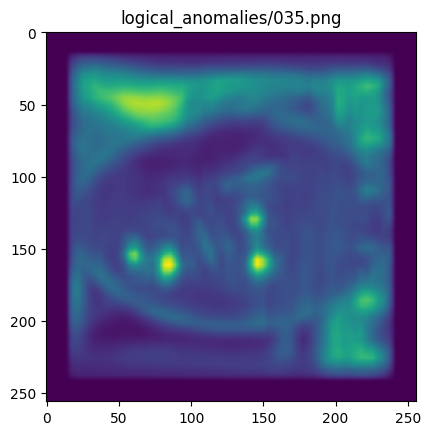

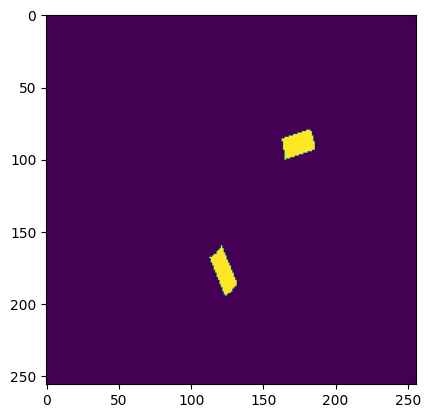

In [99]:
import matplotlib.pyplot as plt

test_data_num = len(loco_datamodule.test_data.samples)
idx = np.random.randint(0, test_data_num)
data = loco_datamodule.test_data[idx]

output = efficienAd(data["image"].to(device))
plt.title("/".join(data['image_path'].split("/")[-2:]))
plt.imshow(output["anomaly_map"].cpu().detach().numpy().squeeze())
plt.show()
plt.imshow(data["mask"].cpu().detach().numpy().squeeze())
plt.show()

# Inference

In [5]:
# efficienAd.EfficientAD = EfficientAd.load_from_checkpoint(cp_pth)
efficienAd.load_state_dict(torch.load(ckpt_path))
efficienAd.eval()
# Loop over the test set and compute the metrics
for data in loco_datamodule.test_dataloader():
    output = efficienAd(data["image"].to(device))

    # Update the image metric
    image_metric.update(output["pred_score"].cpu(), data["label"])

    # Update the pixel metric
    if "anomaly_map" in output:
        pixel_metric.update(
            output["anomaly_map"].squeeze().cpu(), data["mask"].squeeze().cpu())

# Compute the metrics
image_score = image_metric.compute()
print(image_score)
if pixel_metric.update_called:
    pixel_score = pixel_metric.compute()
    print(pixel_score)

c:\Users\weber\miniconda3\envs\AD\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(0.7723)
tensor(0.1572)


In [6]:
batch = efficienAd.EfficientAD._transform(data["image"].to(device)) 
output = efficienAd.EfficientAD(batch)
anomaly_maps, map_st, map_ae = output["anomaly_map"], output["map_st"], output["map_ae"]
# resize back to 256x256 for evaluation
anomaly_maps = resize(anomaly_maps, (256, 256))
pred_score = anomaly_maps.mean()

if efficienAd.k_shot is not None:
    few_shot_scores = 1 - efficienAd._compute_few_shot_scores(map_st, map_ae)
    # pred_score = pred_score / efficienAd._ref_score
    pred_score = pred_score * few_shot_scores

#     few_shot_scores = 1-self._compute_few_shot_scores(map_st, map_ae)
#     pred_score = (pred_score + few_shot_scores) / 2
#     # anomaly_maps = (anomaly_maps + few_shot_scores) / 2
#     # image_scores = (image_scores + few_shot_scores.amax(dim=(-2, -1))) / 2


In [10]:
print(anomaly_maps.mean())
print(few_shot_scores)
print(pred_score)

tensor(281.2927, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0690, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(19.4172, device='cuda:0', grad_fn=<MulBackward0>)


In [11]:
with open("pretrain_process.txt", "a") as f:
    end_time = time.time()
    exe_time = time.strftime('%H:%M:%S',time.localtime(end_time - cur_time))
    f.write(f"Epoch {40} - Time : {exe_time} - Category : test\n")
    f.close()

In [7]:
import time
cur_time = time.time()
print(cur_time)

1716693943.7322369


In [9]:
end_time = time.time()
exe_time = time.strftime('%H:%M:%S',time.localtime(end_time - cur_time))
print(exe_time)

08:02:57


In [7]:
print(efficienAd)

PretrainEfficientAD(
  (EfficientAD): EfficientAd(
    (model): EfficientAdModel(
      (teacher): SmallPatchDescriptionNetwork(
        (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
        (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
        (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (conv4): Conv2d(256, 384, kernel_size=(4, 4), stride=(1, 1))
        (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (student): SmallPatchDescriptionNetwork(
        (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
        (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
        (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (conv4): Conv2d(256, 768, kernel_size=(4, 4), stride=(1, 1))
        (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    